# Importing libraries and modules

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, time, datetime
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score , mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from joblib import Parallel, delayed
import joblib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import altair as alt
import plotly.express as px

# Load CSV

In [107]:
from google.colab import files
data_to_load = files.upload()

Saving CdTe.csv to CdTe.csv


In [108]:
import io
df = pd.read_csv(io.BytesIO(data_to_load['CdTe.csv']))

In [109]:
df.columns

Index(['time', 'P', 'G(i)', 'H_sun', 'T2m', 'WS10m', 'Int'], dtype='object')

**P**: PV system power (W) \\
**G(i)**: Global irradiance on the inclined plane (plane of the array) (W/m2) \\
**H_sun**: Sun height (degree) \\
**T2m**: 2-m air temperature (degree Celsius) \\
**WS10m**: 10-m total wind speed (m/s) \\
**Int**: 1 means solar radiation values are reconstructed \\


# Data exploration

In [110]:
df.head()

,time,P,G(i),H_sun,T2m,WS10m,Int
0,20050101:0010,0.0,0.0,0.0,8.15,2.07,0.0
1,20050101:0110,0.0,0.0,0.0,7.58,2.00,0.0
2,20050101:0210,0.0,0.0,0.0,6.90,2.00,0.0
3,20050101:0310,0.0,0.0,0.0,6.78,1.66,0.0
4,20050101:0410,0.0,0.0,0.0,6.29,1.72,0.0


In [111]:
df.shape

(140256, 7)

In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140256 entries, 0 to 140255
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   time    140256 non-null  object 
 1   P       140256 non-null  float64
 2   G(i)    140256 non-null  float64
 3   H_sun   140256 non-null  float64
 4   T2m     140256 non-null  float64
 5   WS10m   140256 non-null  float64
 6   Int     140256 non-null  float64
dtypes: float64(6), object(1)
memory usage: 7.5+ MB


In [113]:
df.describe()

,P,G(i),H_sun,T2m,WS10m,Int
count,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.0
mean,126.380867,161.501227,13.334678,11.837616,3.201504,0.0
std,216.611201,264.022639,18.084555,7.164644,1.544204,0.0
min,0.000000,0.000000,-0.830000,-10.600000,0.000000,0.0
25%,0.000000,0.000000,0.000000,6.640000,2.140000,0.0
50%,0.000000,0.000000,0.000000,11.690000,2.900000,0.0
75%,152.135000,207.322500,23.580000,16.900000,4.070000,0.0
max,922.490000,1123.540000,64.280000,39.910000,12.690000,0.0


In [114]:
df['time'].duplicated().count()

140256

In [115]:
df['T2m'].value_counts

<bound method IndexOpsMixin.value_counts of 0         8.15
1         7.58
2         6.90
3         6.78
4         6.29
          ... 
140251    1.56
140252    0.87
140253    0.56
140254   -0.10
140255   -0.83
Name: T2m, Length: 140256, dtype: float64>

In [116]:
corr_df = df.corr(method="pearson")

<ipython-input-116-ca3f529fbc0d>:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



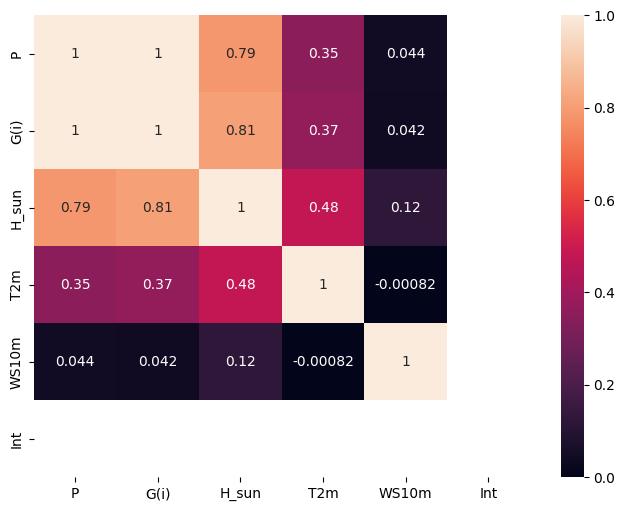

In [117]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True)
plt.show()

In [118]:
corr_df.style.background_gradient(cmap="coolwarm")

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/style.py:3931: RuntimeWarning:

All-NaN slice encountered

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/style.py:3932: RuntimeWarning:

All-NaN slice encountered



,P,G(i),H_sun,T2m,WS10m,Int
P,1.000000,0.998547,0.788519,0.351252,0.043994,nan
G(i),0.998547,1.000000,0.807099,0.370211,0.041824,nan
H_sun,0.788519,0.807099,1.000000,0.476361,0.123027,nan
T2m,0.351252,0.370211,0.476361,1.000000,-0.000818,nan
WS10m,0.043994,0.041824,0.123027,-0.000818,1.000000,nan
Int,nan,nan,nan,nan,nan,nan


# Data visualisation

In [119]:
#df['time'] = pd.to_datetime(df['time'], format='%Y%m%d:%H%M')

In [121]:
base = alt.Chart(df[140089:140256]).encode(x='time')

bar = base.mark_bar().encode(y='P')

line =  base.mark_line(color='red').encode(y='P')

(bar + line).properties(title = "P(W) vs Time(Hour)", width=2000)


alt.LayerChart(...)

In [122]:
chart = alt.Chart(df[140089:140256]).mark_line().encode(x='time',y='T2m').properties(title="T(C°) vs Time(Hour)", width=2000)

chart

alt.Chart(...)

In [123]:
px.line(df[140089:140256], x='time', y=["T2m","G(i)","P"],color_discrete_map={"T2m" : "blue","G(i)" : "red","P": "green"},title="P(W)/G(W/m2)/T(C°) vs Time(Hour)")


In [124]:
df = df.drop(['time','Int', 'H_sun', 'WS10m'], axis=1)

In [125]:
df

,P,G(i),T2m
0,0.0,0.0,8.15
1,0.0,0.0,7.58
2,0.0,0.0,6.90
3,0.0,0.0,6.78
4,0.0,0.0,6.29
...,...,...,...
140251,0.0,0.0,1.56
140252,0.0,0.0,0.87
140253,0.0,0.0,0.56
140254,0.0,0.0,-0.10


# Model preparation

In [126]:
df = df.rename(columns={'T2m':'temperature_2m','G(i)':'direct_radiation' })

In [127]:
df

,P,direct_radiation,temperature_2m
0,0.0,0.0,8.15
1,0.0,0.0,7.58
2,0.0,0.0,6.90
3,0.0,0.0,6.78
4,0.0,0.0,6.29
...,...,...,...
140251,0.0,0.0,1.56
140252,0.0,0.0,0.87
140253,0.0,0.0,0.56
140254,0.0,0.0,-0.10


In [128]:
X = df.drop('P',axis = 1)

In [129]:
X

,direct_radiation,temperature_2m
0,0.0,8.15
1,0.0,7.58
2,0.0,6.90
3,0.0,6.78
4,0.0,6.29
...,...,...
140251,0.0,1.56
140252,0.0,0.87
140253,0.0,0.56
140254,0.0,-0.10


In [130]:
X = X[['temperature_2m', 'direct_radiation' ]]

In [131]:
X

,temperature_2m,direct_radiation
0,8.15,0.0
1,7.58,0.0
2,6.90,0.0
3,6.78,0.0
4,6.29,0.0
...,...,...
140251,1.56,0.0
140252,0.87,0.0
140253,0.56,0.0
140254,-0.10,0.0


In [132]:
y = df.loc[:,'P']

In [133]:
X_train,X_test, y_train ,y_test = train_test_split(X,y,test_size = .2, random_state = 64)

In [134]:
X_train.shape , X_test.shape , y_train.shape , y_test.shape

((112204, 2), (28052, 2), (112204,), (28052,))

# First model: Logistic Regression

In [135]:
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)

In [136]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Model has a RMSE of {}.".format(rmse))

Model has a RMSE of 10.953099159167447.


In [137]:
r2_score(y_test,y_pred)

0.9974486356232652

# Second model : DecisionTreeRegressor

In [138]:
reg = DecisionTreeRegressor()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

In [139]:
rmse = mean_squared_error(y_test, y_pred, squared=False)

print("Model has a RMSE of {}.".format(rmse))

Model has a RMSE of 5.1588197571112175.


In [140]:
r2_score(y_test,y_pred)

0.9994340225117297

# Third model : KNearest Neighbors Regressor

In [141]:
Knr = KNeighborsRegressor(n_neighbors=3)
Knr.fit(X_train, y_train)
y_pred = Knr.predict(X_test)

In [142]:
rmse = mean_squared_error(y_test, y_pred, squared=False)

print("Model has a RMSE of {}.".format(rmse))

Model has a RMSE of 4.1876012300008725.


In [143]:
r2_score(y_test,y_pred)

0.9996270684844976

# Fourth model : MLP

In [144]:
model = Sequential()

model.add(Dense(256,activation='relu',input_dim= 2))
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(1))


In [145]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 256)               768       
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 41985 (164.00 KB)
Trainable params: 41985 (164.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [146]:
model.compile(optimizer='adam', loss = 'mse')

In [147]:
history = model.fit(x = X_train,y = y_train,validation_data=(X_test,y_test),epochs = 200,batch_size=512)

Epoch 1/200
220/220 [==============================] - 3s 9ms/step - loss: 1099.2831 - val_loss: 52.0634
Epoch 2/200
220/220 [==============================] - 3s 12ms/step - loss: 48.8713 - val_loss: 49.7241
Epoch 3/200
220/220 [==============================] - 2s 10ms/step - loss: 43.9951 - val_loss: 48.6748
Epoch 4/200
220/220 [==============================] - 2s 8ms/step - loss: 37.8821 - val_loss: 41.2904
Epoch 5/200
220/220 [==============================] - 2s 7ms/step - loss: 33.9985 - val_loss: 32.0354
Epoch 6/200
220/220 [==============================] - 2s 7ms/step - loss: 32.4049 - val_loss: 45.5760
Epoch 7/200
220/220 [==============================] - 2s 7ms/step - loss: 32.0357 - val_loss: 54.5158
Epoch 8/200
220/220 [==============================] - 2s 7ms/step - loss: 31.0672 - val_loss: 30.3795
Epoch 9/200
220/220 [==============================] - 2s 9ms/step - loss: 29.7010 - val_loss: 29.8827
Epoch 10/200
220/220 [==============================] - 3s 12ms/step 

In [148]:
loss_train = history.history['loss']

In [149]:
loss_val = history.history['val_loss']

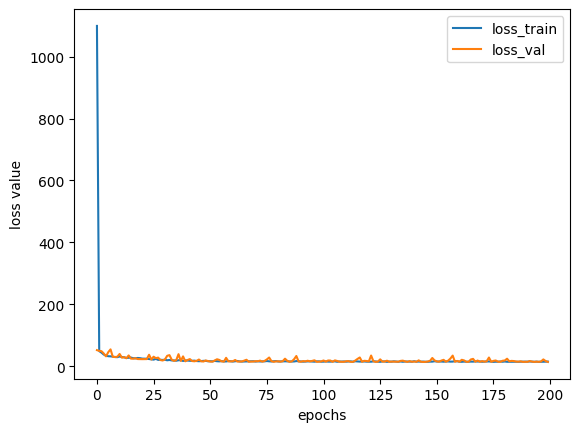

In [150]:
plt.plot(loss_train,label = 'loss_train')
plt.plot(loss_val,label = 'loss_val')
plt.xlabel('epochs')
plt.ylabel('loss value')
plt.legend()

In [151]:
y_pred = model.predict(X_test)

877/877 [==============================] - 2s 2ms/step


In [152]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Model has a RMSE of {}.".format(rmse))

Model has a RMSE of 3.742183981478674.


In [153]:
print('RMSE on train:', mean_squared_error(y_train, model.predict(X_train), squared=False))
print('RMSE on test:', mean_squared_error(y_test, model.predict(X_test), squared=False))

3507/3507 [==============================] - 7s 2ms/step
RMSE on train: 3.6280833909335275
877/877 [==============================] - 2s 2ms/step
RMSE on test: 3.742183981478674


In [154]:
r2_score(y_test,y_pred)

0.999702183524614

# Save the optimal trained model

In [156]:
# Save the model as a pickle in a file
joblib.dump(model, 'CdTe_modèle.pkl')

# Load the model from the file
model_from_joblib = joblib.load('CdTe_modèle.pkl')
